In [195]:
import casadi as ca
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

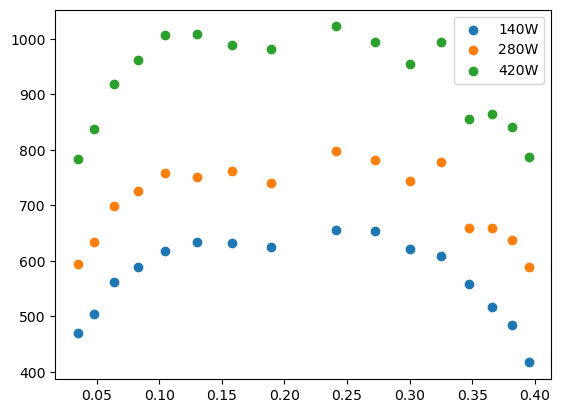

In [196]:
# temperature profile
tc_pos = json.load(open('tc_pos.json'))
T_140 = json.load(open('Temp_profile_140W.json'))
T_280 = json.load(open('Temp_profile_280W.json'))
T_420 = json.load(open('Temp_profile_420W.json'))

plt.scatter(tc_pos, T_140, label='140W')
plt.scatter(tc_pos, T_280, label='280W')
plt.scatter(tc_pos, T_420, label='420W')
plt.legend()
plt.show()

In [197]:
# Geometry
L = 430e-3 # reactor length [m]
ID = 5.03e-3 # inner diameter [m]
OD = 6.33e-3 # outer diameter [m]
tkn = OD - ID # wall thickness [m]

Ai = np.pi * ID**2 / 4 # inner cross-sectional area [m2]
Ao = np.pi * OD**2 / 4 # outer cross-sectional area [m2]
Aw = Ao - Ai # wall cross-sectional area [m2]

pri = np.pi * ID # inner perimeter [m]
pro = np.pi * OD # outer perimeter [m]

# Grid
dz = 0.001 # grid size [m]
n_nodes = int(L/dz) + 1 # number of grid points

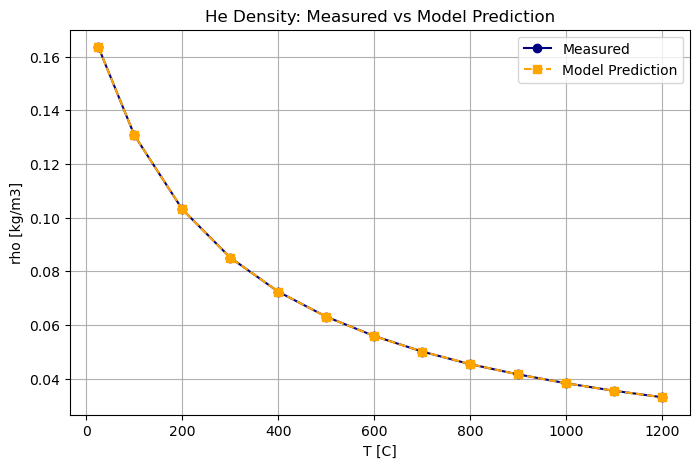

Text(0.5, 1.0, 'KanthalD Heat Capacity: Measured vs Model Prediction')

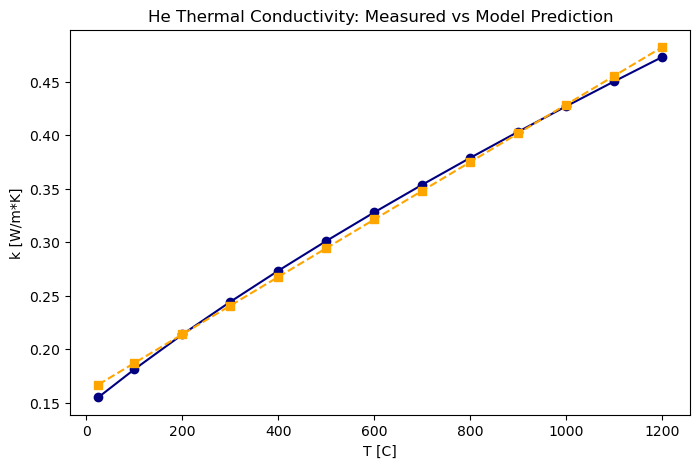

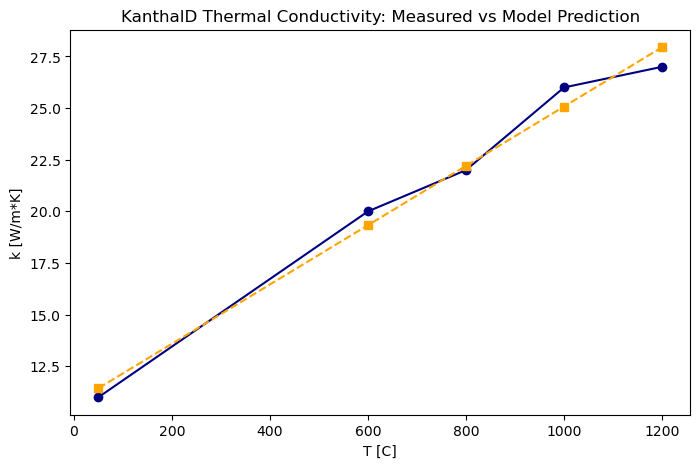

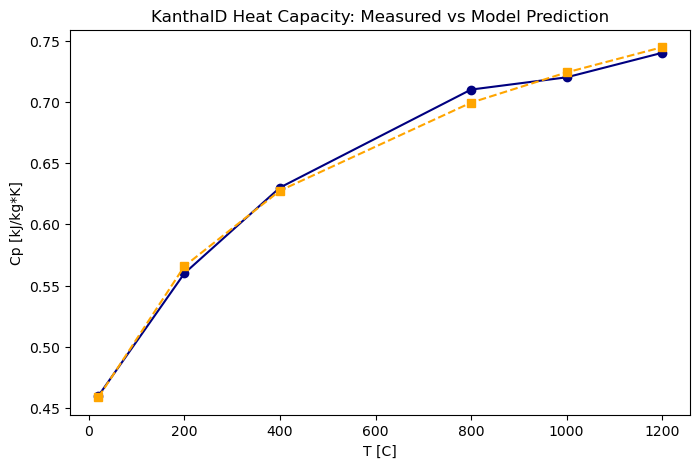

In [198]:
# Material properties
path_he = '../data/He_property.csv'
path_kt = '../data/KanthalD_property.csv'
df_he = pd.read_csv(path_he)
df_kt = pd.read_csv(path_kt)

# He molar weight
Mw_he = 4.0026 # g/mol

# He density
def rho_he_fit(T, a, b, c):
    return a / (b + T) + c
prho_he, _ = curve_fit(rho_he_fit, df_he['T [C]'], df_he['rho [kg/m3]'])
a_rho_he, b_rho_he, c_rho_he = prho_he
def rho_he(T):
    return a_rho_he / (b_rho_he + T) + c_rho_he
fitted_rho = rho_he(df_he['T [C]'])
plt.figure(figsize=(8,5))
plt.plot(df_he['T [C]'], df_he['rho [kg/m3]'], marker='o', linestyle='-', color='navy', label='Measured')
plt.plot(df_he['T [C]'], fitted_rho, marker='s', linestyle='--', color='orange', label='Model Prediction')
plt.xlabel('T [C]')
plt.ylabel('rho [kg/m3]')
plt.title('He Density: Measured vs Model Prediction')
plt.legend()
plt.grid(True)
plt.show()

# He heat capacity
Cp_he = 20.786 # J/mol/K, heat capacity of helium

# He thermal conductivity
def k_he_fit(T, a, b):
    return a*T + b
pk_he, _ = curve_fit(k_he_fit, df_he['T [C]'], df_he['Tc [W/m*K]'])
a_k_he, b_k_he = pk_he
def k_he(T):
    return a_k_he*T + b_k_he
fitted_k = k_he(df_he['T [C]'])
plt.figure(figsize=(8,5))
plt.plot(df_he['T [C]'], df_he['Tc [W/m*K]'], marker='o', linestyle='-', color='navy', label='Measured')
plt.plot(df_he['T [C]'], fitted_k, marker='s', linestyle='--', color='orange', label='Model Prediction')
plt.xlabel('T [C]')
plt.ylabel('k [W/m*K]')
plt.title('He Thermal Conductivity: Measured vs Model Prediction')

# kanthalD density
rho_kt = 7250 # kg/m3

# kanthalD thermal conductivity
def k_kt_fit(T, a, b):
    return a*T + b
df_kt_k = df_kt[df_kt['k [W/m*K]'].notna()]
pk_kt, _ = curve_fit(k_kt_fit, df_kt_k['T [C]'], df_kt_k['k [W/m*K]'])
a_k_kt, b_k_kt = pk_kt
def k_kt(T):
    return a_k_kt*T + b_k_kt
fitted_k_kt = k_kt(df_kt_k['T [C]'])
plt.figure(figsize=(8,5))
plt.plot(df_kt_k['T [C]'], df_kt_k['k [W/m*K]'], marker='o', linestyle='-', color='navy', label='Measured')
plt.plot(df_kt_k['T [C]'], fitted_k_kt, marker='s', linestyle='--', color='orange', label='Model Prediction')
plt.xlabel('T [C]')
plt.ylabel('k [W/m*K]')
plt.title('KanthalD Thermal Conductivity: Measured vs Model Prediction')

# kanthalD heat capacity
def Cp_kt_fit(T, a, b, c):
    return a*np.log(T + b) + c
df_kt_Cp = df_kt[df_kt['Cp [kJ/kg*K]'].notna()]
pk_kt, _ = curve_fit(Cp_kt_fit, df_kt_Cp['T [C]'], df_kt_Cp['Cp [kJ/kg*K]'])
a_Cp_kt, b_Cp_kt, c_Cp_kt = pk_kt
def Cp_kt(T):
    return (a_Cp_kt*np.log(T + b_Cp_kt) + c_Cp_kt) # kJ/kg/K
fitted_Cp_kt = Cp_kt(df_kt_Cp['T [C]'])
plt.figure(figsize=(8,5))
plt.plot(df_kt_Cp['T [C]'], df_kt_Cp['Cp [kJ/kg*K]'], marker='o', linestyle='-', color='navy', label='Measured')
plt.plot(df_kt_Cp['T [C]'], fitted_Cp_kt, marker='s', linestyle='--', color='orange', label='Model Prediction')
plt.xlabel('T [C]')
plt.ylabel('Cp [kJ/kg*K]')
plt.title('KanthalD Heat Capacity: Measured vs Model Prediction')

In [199]:
# Feed conditions
Fv_std = 50 # mL/min at standard conditions
Fw = Fv_std * 1e-6 / 60 * rho_he(0) # kg/s, feed mass flow rate
F = Fw / Mw_he * 1000 # mol/s, feed molar flow rate
P = 101325 # Pa, feed pressure
Tamb = 25.0  # C, ambient temperature
Pw = 140 # W, electric power

In [ ]:
# Energy Balance
Tw = ca.MX.sym('Tw', n_nodes)
Tg = ca.MX.sym('Tg', n_nodes)

res = []
for i in range(n_nodes):
    Qelec = Pw * dz/L # W, electric power per unit length
    Awg = pri * dz # m2, wall-gas contact area
    Aout = pro * dz # m2, wall-outer surface contact area
    hout = 10 # W/m2/K, heat transfer coefficient

    if i == 0:
        # Dirichilet B.C. at inlet:
        res.append(Tw[i] - Tamb)
        res.append(Tg[i] - Tamb)
    elif i == n_nodes-1:
        res.append(Tw[i] - Tamb)
        res.append(Tg[i] - Tamb) 
    else:
        hwg = 4.36*k_he(Tg[i])/ID
        Qwg = hwg * Awg * (Tw[i] - Tg[i])
        Qout = hout * Aout * (Tw[i] - Tamb)
        res.append(k_kt(Tw[i]) * Aw *(Tw[i+1] - 2*Tw[i] + Tw[i-1]) / dz**2 + Qelec/dz - Qwg/dz - Qout/dz)
        res.append(F * Cp_he * (Tg[i] - Tg[i+1])/dz - Qwg/dz)

residuals = ca.vertcat(*res)

In [201]:
# Decision variables
x = ca.vertcat(Tw, Tg)

print(f'Total decision variables: {x.shape[0]}')
print(f'    - Tw : {n_nodes} variables')
print(f'    - Tg : {n_nodes} variables')
print(f'Total residuals: {len(res)}')

# Compute Jacobian: dg/dx
constraints = ca.vertcat(*res)
jacobian = ca.jacobian(constraints, x)

print(f'Jacobian shape: {jacobian.shape}')

# Get sparsity pattern
sparsity = jacobian.sparsity()
print(f'Jacobian sparsity: {sparsity.nnz()} non-zeros out of {jacobian.shape[0]*jacobian.shape[1]} total')
print(f'Sparsity ratio: {100*sparsity.nnz()/(jacobian.shape[0]*jacobian.shape[1]):.2f}%')


Total decision variables: 862
    - Tw : 431 variables
    - Tg : 431 variables
Total residuals: 862
Jacobian shape: (862, 862)
Jacobian sparsity: 3007 non-zeros out of 743044 total
Sparsity ratio: 0.40%


In [202]:
# Objective function (minimize residual)
from tkinter import N


objective = sum([res_i**2 for res_i in res])

# NLP problem
nlp = {
    'x': x,
    'f': objective,
    'g': constraints
}

# Solver options
opts = {
    'ipopt.print_level': 5,
    'ipopt.max_iter': 1000,
    'print_time': 0
}

# Create solver
solver = ca.nlpsol('solver', 'ipopt', nlp, opts)

# Initial guess
x0 = np.ones(2*n_nodes) * Tamb

# bounds on decision variables
lbx = np.zeros(2*n_nodes)
ubx = np.ones(2*n_nodes) * np.inf

# bounds on constraints (equality: g = 0)
lbg = np.zeros(len(res))
ubg = np.zeros(len(res))

# solve NLP
sol = solver(x0=x0, lbx=lbx, ubx=ubx, lbg=lbg, ubg=ubg)

print('Solver status:', solver.stats()['return_status'])
print('Objective:', sol['f'])

This is Ipopt version 3.14.19, running with linear solver MUMPS 5.8.1.

Number of nonzeros in equality constraint Jacobian...:     3007
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3438

Total number of variables............................:      862
                     variables with only lower bounds:      862
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      862
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.5475392e+07 3.26e+02 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

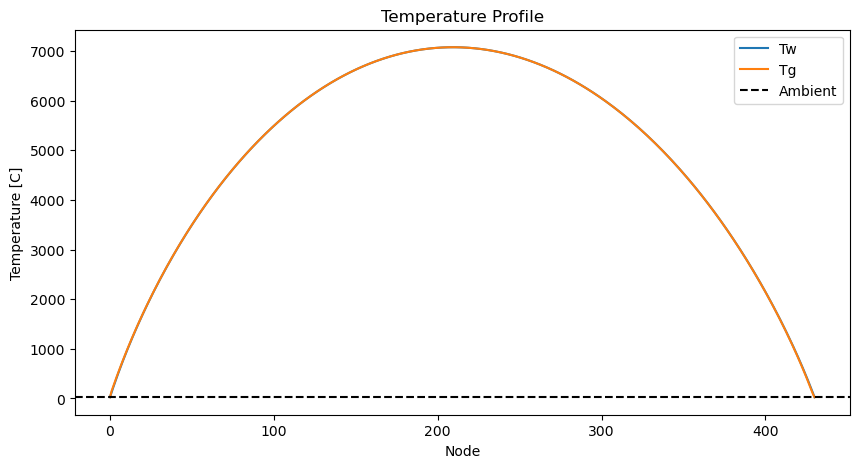

In [203]:
# Extract and verify solution
x_sol = sol['x'].full().flatten()
Tw_sol = x_sol[:n_nodes]
Tg_sol = x_sol[n_nodes:]

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(Tw_sol, label='Tw')
plt.plot(Tg_sol, label='Tg')
plt.axhline(Tamb, color='black', linestyle='--', label='Ambient')
plt.xlabel('Node')
plt.ylabel('Temperature [C]')
plt.title('Temperature Profile')
plt.legend()
plt.show()




